In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
from torch import nn

In [3]:
import kagglehub

In [4]:
anime_path = kagglehub.dataset_download(handle='splcher/animefacedataset')

In [5]:
anime_path

'/Users/lesliehuang/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3'

In [6]:
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

In [7]:
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize([.5, .5, .5], [.5, .5, .5]),
])

In [8]:
train_data = ImageFolder(root=anime_path, transform=transform)

In [9]:
train_data

Dataset ImageFolder
    Number of datapoints: 63565
    Root location: /Users/lesliehuang/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [10]:
batch_size = 128

In [11]:
from torch.utils.data import DataLoader

In [12]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [13]:
train_loader

In [14]:
image0, _ = train_data[0]

In [15]:
image0.shape

torch.Size([3, 64, 64])

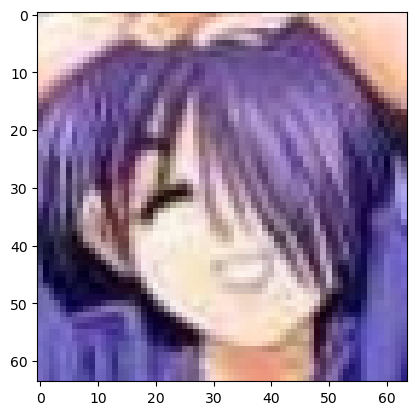

In [16]:
plt.imshow(image0.permute(1, 2, 0)*.5 + .5)
plt.show()

In [17]:
def plot_images(imgs):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(imgs[i].permute(1,2,0)/2+0.5)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.show()

In [18]:
imgs, _ = next(iter(train_loader))

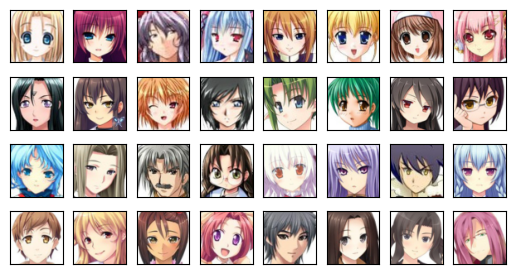

In [19]:
plot_images(imgs)

In [20]:
device = 'cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [21]:
device

'mps'

In [22]:
D = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(.2, inplace=True),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=128),
    nn.LeakyReLU(.2, inplace=True),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=256),
    nn.LeakyReLU(.2, inplace=True),
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=512),
    nn.LeakyReLU(.2, inplace=True),
    nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Sigmoid(),
    nn.Flatten(),
).to(device)

In [23]:
G = nn.Sequential(
    nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
).to(device)

In [24]:
sample_noise = torch.randn(32, 100, 1, 1)

In [25]:
loss_fn = nn.BCELoss()
lr = .0002
optimG = torch.optim.Adam(G.parameters(), lr=lr, betas=(.5, .999))
optimD = torch.optim.Adam(D.parameters(), lr=lr, betas=(.5, .999))


In [26]:
def test_epoch():
    noise=torch.randn(32,100,1,1).to(device=device)
    fake_samples=G(noise).cpu().detach()
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        img=(fake_samples.cpu().detach()[i]/2+0.5).permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.show()

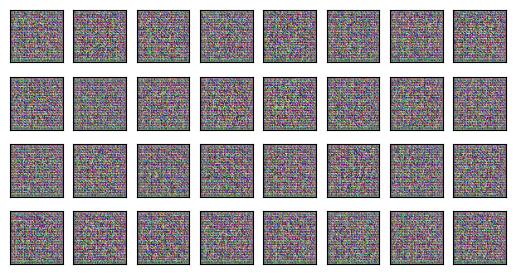

In [27]:
test_epoch()

In [28]:
def train_D_on_real(real_samples):
    optimD.zero_grad()
    output = D(real_samples.to(device))
    loss = loss_fn(output, torch.ones_like(output, dtype=torch.float32))
    loss.backward() 
    optimD.step()
    return loss


In [29]:
def train_D_on_fake():
    optimD.zero_grad()
    fake_samples = G(torch.randn(batch_size, 100, 1, 1).to(device))
    output = D(fake_samples)
    loss = loss_fn(output, torch.zeros_like(output, dtype=torch.float32))
    loss.backward()
    optimD.step()
    return loss

In [30]:
def train_G():
    optimG.zero_grad()
    generated_result = G(torch.randn(batch_size, 100, 1, 1).to(device))
    output = D(generated_result)
    loss = loss_fn(output, torch.ones_like(output, dtype=torch.float32))
    loss.backward()
    optimG.step()
    return loss

In [31]:
from tqdm import tqdm
def train(epochs=20):
    for i in range(epochs):
        gloss, dloss = 0, 0
        for n, (real_samples, _) in enumerate(tqdm(train_loader)):
            loss_D = train_D_on_real(real_samples)
            dloss += loss_D
            loss_D = train_D_on_fake()
            dloss += loss_D
            gloss += train_G()
        gloss /= n
        dloss /= n
        print(f"epoch {i+1}, dloss: {dloss}, gloss {gloss}")
        test_epoch()


100%|██████████| 497/497 [03:11<00:00,  2.59it/s]


epoch 1, dloss: 0.5491030216217041, gloss 6.62932825088501


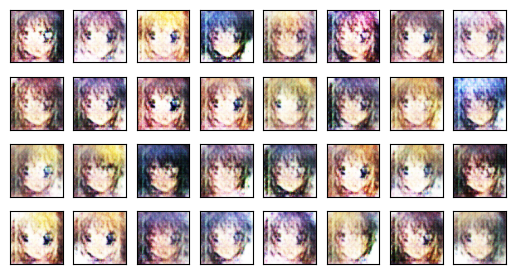

100%|██████████| 497/497 [03:16<00:00,  2.53it/s]


epoch 2, dloss: 0.47075966000556946, gloss 6.83401346206665


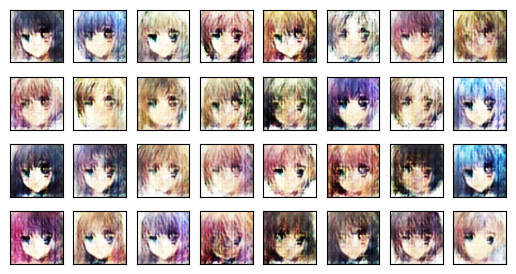

100%|██████████| 497/497 [03:19<00:00,  2.49it/s]


epoch 3, dloss: 0.3965035378932953, gloss 6.926262855529785


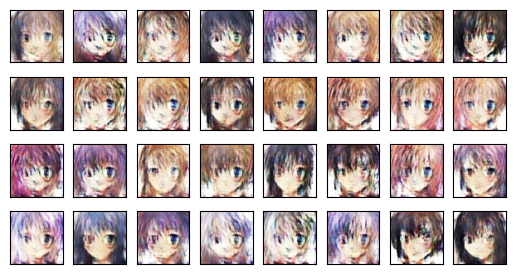

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 4, dloss: 0.31443560123443604, gloss 7.3207011222839355


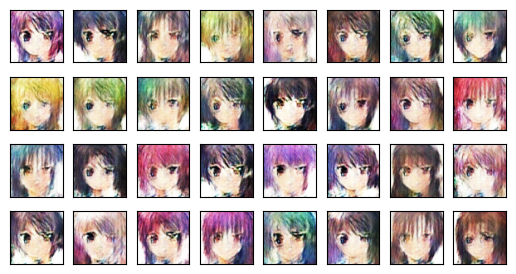

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 5, dloss: 0.2976894974708557, gloss 7.672689914703369


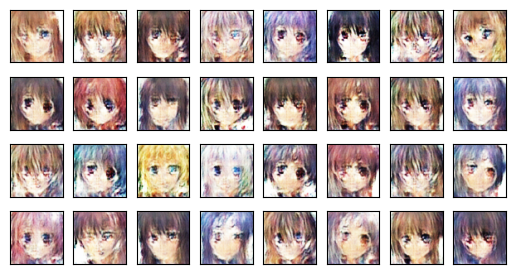

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 6, dloss: 0.24722258746623993, gloss 7.825091361999512


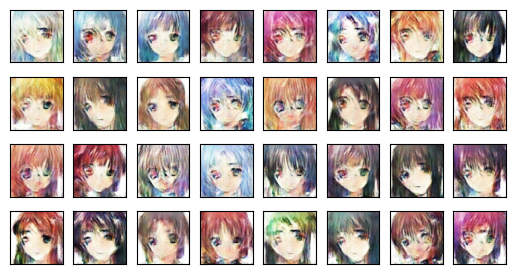

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 7, dloss: 0.2741042673587799, gloss 7.914942264556885


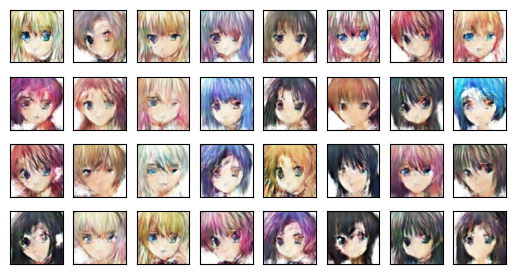

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 8, dloss: 0.27991488575935364, gloss 7.603189468383789


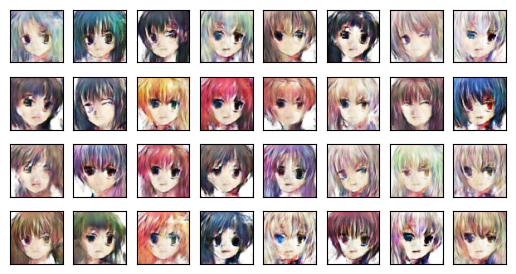

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 9, dloss: 0.27031734585762024, gloss 7.731869697570801


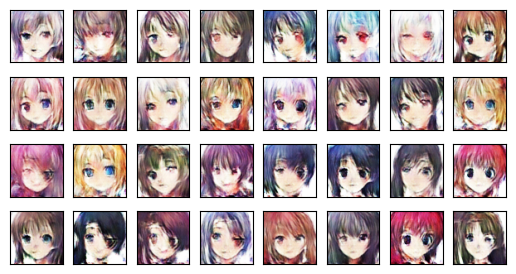

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 10, dloss: 0.2318737655878067, gloss 7.448741436004639


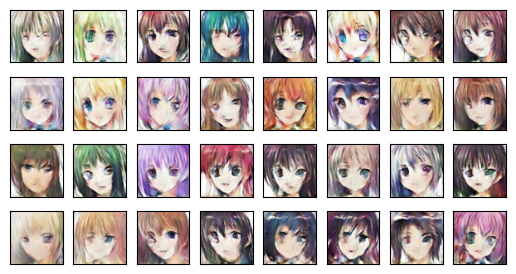

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 11, dloss: 0.292093425989151, gloss 7.468893527984619


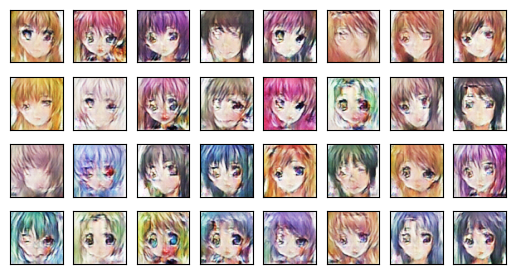

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 12, dloss: 0.20731888711452484, gloss 7.113922595977783


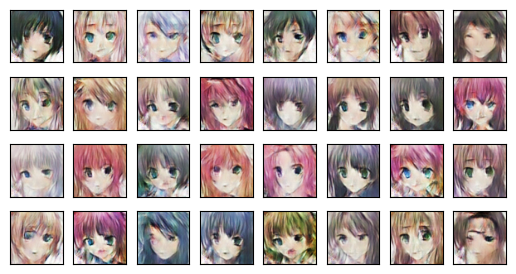

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 13, dloss: 0.2525971233844757, gloss 7.718055248260498


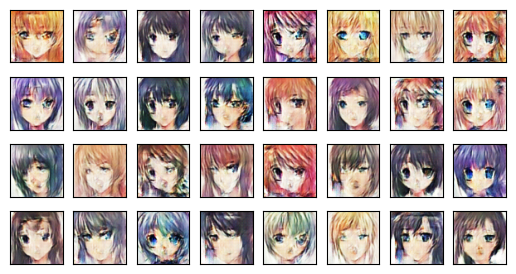

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 14, dloss: 0.18656949698925018, gloss 7.2039361000061035


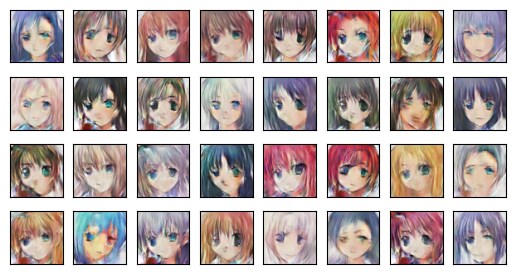

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 15, dloss: 0.1875971257686615, gloss 7.77157735824585


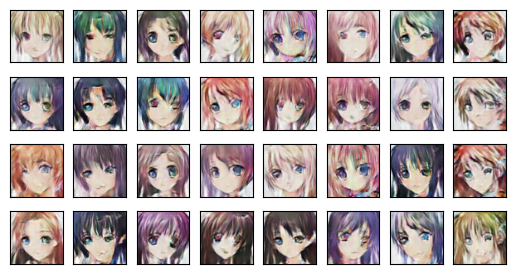

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 16, dloss: 0.2422851175069809, gloss 7.323676109313965


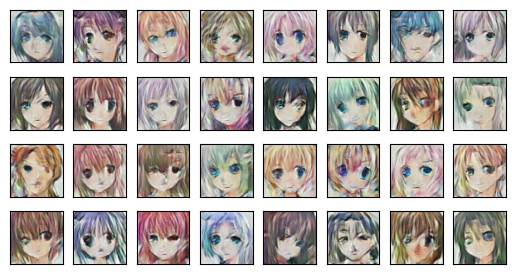

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 17, dloss: 0.21239683032035828, gloss 7.004659652709961


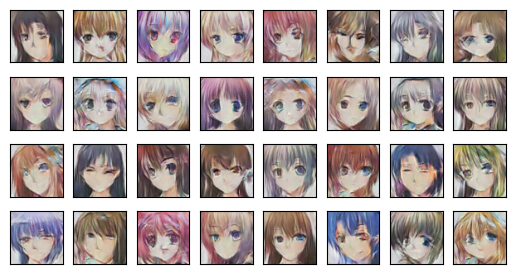

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 18, dloss: 0.18639150261878967, gloss 6.770744800567627


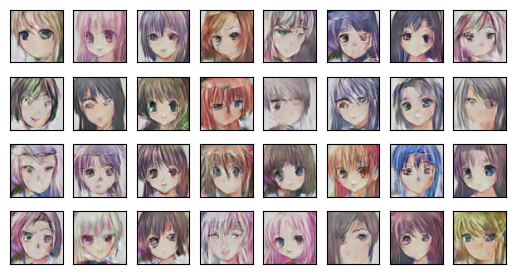

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 19, dloss: 0.2711744010448456, gloss 6.7726216316223145


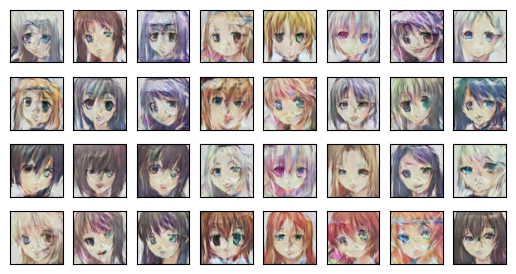

100%|██████████| 497/497 [03:20<00:00,  2.48it/s]


epoch 20, dloss: 0.236794114112854, gloss 6.494296073913574


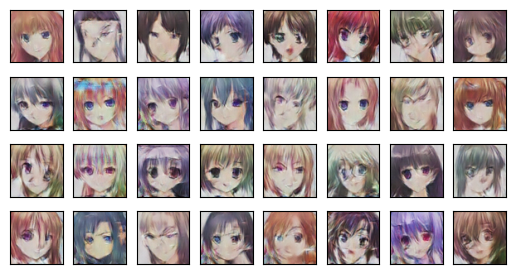

In [32]:
train()

In [33]:
new_G = G.to('cpu')

In [34]:
torch.jit.script(new_G).save('files/anime_gen.pt')